Three types of tests that assess different behaviors of your ML models:

## Invariant testing

Tests whether a ML models produces consistent results under different conditions. Example - paraphrasing:

- **Positive**: *The hotel room was great! It was spacious, clean and had a nice view of the city.*
- **Negative**: *The hotel room wasn't bad. It wasn't cramped, dirty, and had a decent view of the city.*

The model should give the same result for both pieces of texts! To perform the invariant test, we can use a framework for behavior-drive development called **behave**. While `pytest` is an option for implementing the test, `behave` is better suited for defining and validating the behavior of ML models. 

In [1]:
!pip install behave

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.8/136.8 kB 3.1 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24591 sha256=0e579ae9e4c9b3cb5c2927840e404c367a01e0e2313291fc1bbdccb39575456e
  Stored in directory: /home/ggonzalv/.cache/pip/wheels/70/4b/f0/eaf5a8de646d8676dc25caa01949b9f9d883b8fa2efb435bc3
Successfully built parse


In [3]:
!pip install textblob

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.8/636.8 kB 7.4 MB/s eta 0:00:00a 0:00:01
  Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 770.5/770.5 kB 9.9 MB/s eta 0:00:0000:0100:01


We should create two different files: a *feature* file (`.feature`) and a *step* file (`.py`):

```
- features
|---- invariant_test_sentiment.feature
|---- steps/
   |---- invariant_test_sentiment.py
```

The feature file describes a feature of a ML model. It contains the three steps that will be then described in the step file:

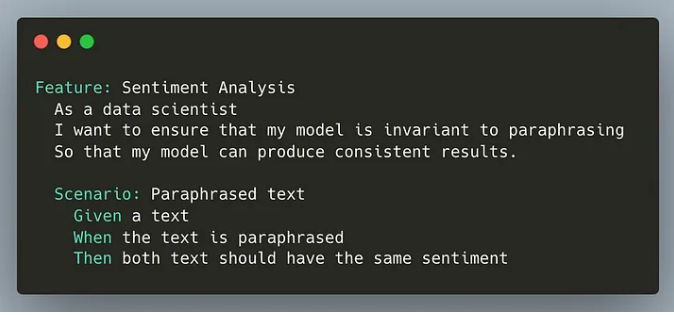

The *given*, *when* and *then* are the actual steps that will be executed by behave during test. Then, the `invariant_test_sentiment.py` file contains the following code:

In [4]:
from behave import given, then, when
from textblob import TextBlob


@given("a text") # A decorator is used for each step. It accepts a string containing the rest of the phrase in the feature file.
def step_given_positive_sentiment(context): # The context variable allows you to share values between steps
    context.sent = "The hotel room was great! It was spacious, clean and had a nice view of the city."


@when("the text is paraphrased")
def step_when_paraphrased(context):
    context.sent_paraphrased = "The hotel room wasn't bad. It wasn't cramped, dirty, and had a decent view of the city."


@then("both text should have the same sentiment")
def step_then_sentiment_analysis(context):
    # Get sentiment of each sentence
    sentiment_original = TextBlob(context.sent).sentiment.polarity
    sentiment_paraphrased = TextBlob(context.sent_paraphrased).sentiment.polarity

    # Print sentiment
    print(f"Sentiment of the original text: {sentiment_original:.2f}")
    print(f"Sentiment of the paraphrased sentence: {sentiment_paraphrased:.2f}")

    # Assert that both sentences have the same sentiment
    both_positive = (sentiment_original > 0) and (sentiment_paraphrased > 0)
    both_negative = (sentiment_original < 0) and (sentiment_paraphrased < 0)
    assert both_positive or both_negative

Then one can test the code using the command `behave features/invariant_test_sentiment.feature`.

## Directional testing

Directional testing is a statistical method used to assess whether the impact of an independent variable on a dependent variable is in a particular direction, either positive or negative. Example: Check whether the presence of a specific word has a positive/negative effect on the sentiment score of a given text.

The implementation of this test follows the same structure as before:

```
- features
|---- directional_test_sentiment.feature
|---- steps/
   |---- directional_test_sentiment.py
```

The `directional_test_sentiment.feature` and `directional_test_sentiment.py` files look like this:

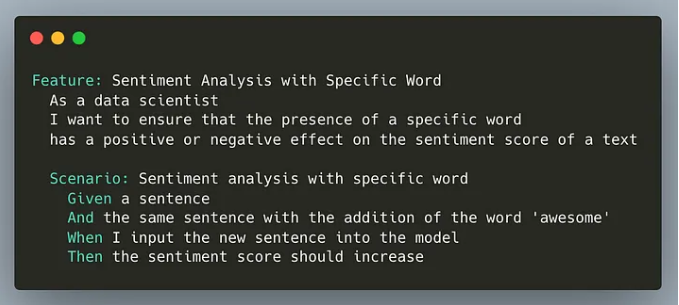

In [6]:
from behave import given, then, when
from textblob import TextBlob


@given("a sentence")
def step_given_positive_word(context):
    context.sent = "I love this product" 


@given("the same sentence with the addition of the word '{word}'") # {word} is a parameter syntax. The value of {word} is taken from the feature file between ''
def step_given_a_positive_word(context, word): # 
    context.new_sent = f"I love this {word} product"


@when("I input the new sentence into the model")
def step_when_use_model(context):
    context.sentiment_score = TextBlob(context.sent).sentiment.polarity
    context.adjusted_score = TextBlob(context.new_sent).sentiment.polarity


@then("the sentiment score should increase")
def step_then_positive(context):
    assert context.adjusted_score > context.sentiment_score

AmbiguousStep: @given('a sentence') has already been defined in
  existing step @given('a sentence') at ../../../tmp/ipykernel_72/1562713161.py:5

Again, to run the code, one should just type:

`behave features/directional_test_sentiment.feature`

## Minimum functionality

Minimum functionality testing verifies if the system or product meets the medium requirements and is functional for its intended use. Example: Test the model is capable of handling different types of inputs:

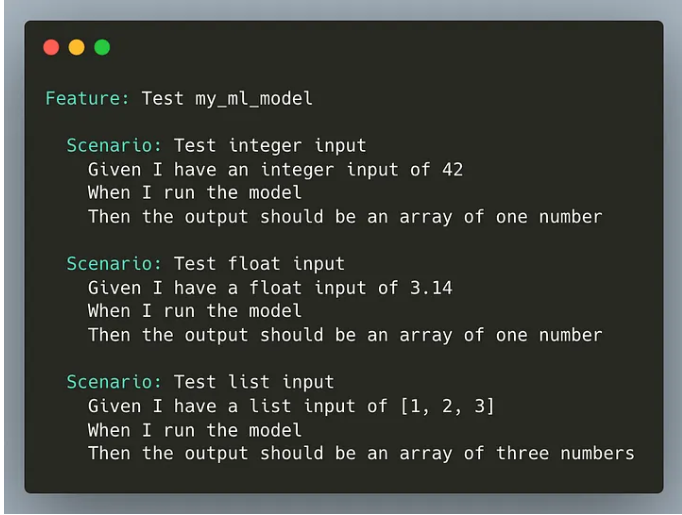

In [7]:
from behave import given, then, when

import numpy as np
from sklearn.linear_model import LinearRegression
from typing import Union


def predict(input_data: Union[int, float, str, list]):
    """Create a model to predict input data"""

    # Reshape the input data
    if isinstance(input_data, (int, float, list)):
        input_array = np.array(input_data).reshape(-1, 1)
    else:
        raise ValueError("Input type not supported")

    # Create a linear regression model
    model = LinearRegression()

    # Train the model on a sample dataset
    X = np.array([[1], [2], [3], [4], [5]])
    y = np.array([2, 4, 6, 8, 10])
    model.fit(X, y)

    # Predict the output using the input array
    return model.predict(input_array)


@given("I have an integer input of {input_value}")
def step_given_integer_input(context, input_value):
    context.input_value = int(input_value)


@given("I have a float input of {input_value}")
def step_given_float_input(context, input_value):
    context.input_value = float(input_value)


@given("I have a list input of {input_value}")
def step_given_list_input(context, input_value):
    context.input_value = eval(input_value)


@when("I run the model")
def step_when_run_model(context):
    context.output = predict(context.input_value)


@then("the output should be an array of one number")
def step_then_check_output(context):
    assert isinstance(context.output, np.ndarray)
    assert all(isinstance(x, (int, float)) for x in context.output)
    assert len(context.output) == 1


@then("the output should be an array of three numbers")
def step_then_check_output(context):
    assert isinstance(context.output, np.ndarray)
    assert all(isinstance(x, (int, float)) for x in context.output)
    assert len(context.output) == 3

Again, to run the code, one should just type:

`behave features/minimum_func_test_input.feature`

## References

- [YouTube](https://www.youtube.com/watch?v=gUttUxyNbIA)
- [Medium](https://towardsdatascience.com/write-readable-tests-for-your-machine-learning-models-with-behave-ec4a27b91490)